In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. Install Required Libraries
!pip install albumentations opencv-python-headless torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
# 3. Import Libraries for Data Augmentation
import os
import cv2
import numpy as np
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomRotate90, Transpose, ShiftScaleRotate,
    Blur, OpticalDistortion, GridDistortion, ElasticTransform, CLAHE,BboxParams, RandomBrightnessContrast
)
from albumentations import Compose

In [ ]:
# 4. Define augmentation pipeline with bounding box support
augmentation_pipeline = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
    Transpose(p=0.5),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.10, rotate_limit=45, p=0.5),
    Blur(blur_limit=3, p=0.2),
    OpticalDistortion(p=0.3),
    GridDistortion(p=0.3),
    ElasticTransform(p=0.1),
    CLAHE(p=0.5),
    RandomBrightnessContrast(p=0.5)
], bbox_params=BboxParams(format='yolo', label_fields=['category_id']))

In [ ]:
# 5. Paths
input_image_dir = '/content/drive/MyDrive/wtdataset/images'
input_label_dir = '/content/drive/MyDrive/wtdataset/labels'
output_image_dir = '/content/drive/MyDrive/wtdataset/augmented/augmented_images'
output_label_dir = '/content/drive/MyDrive/wtdataset/augmented/augmented_labels'

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

In [ ]:
# 6. Helper Functions to Read and Write YOLO Labels
def read_yolo_labels(label_path):
    with open(label_path, 'r') as file:
        labels = [line.strip().split() for line in file.readlines()]
    return labels

def write_yolo_labels(label_path, labels):
    with open(label_path, 'w') as file:
        for label in labels:
            file.write(' '.join(map(str, label)) + '\n')


In [ ]:
# 7. Process Each Image and Its Annotations
image_files = os.listdir(input_image_dir)
count = 0

for image_file in image_files:
    image_path = os.path.join(input_image_dir, image_file)
    label_path = os.path.join(input_label_dir, os.path.splitext(image_file)[0] + '.txt')

    if not os.path.exists(label_path):
        continue

    image = cv2.imread(image_path)
    img_height, img_width = image.shape[:2]

    labels = read_yolo_labels(label_path)
    bboxes = []
    categories = []

    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label)
        bboxes.append([x_center, y_center, width, height])
        categories.append(int(class_id))

    for i in range(16):  # Generate 16 augmented images per original image
        augmented = augmentation_pipeline(image=image, bboxes=bboxes, category_id=categories)
        augmented_image = augmented['image']
        augmented_bboxes = augmented['bboxes']

        augmented_labels = []
        for bbox, category in zip(augmented_bboxes, categories):
            x_center, y_center, width, height = bbox
            augmented_labels.append([category, x_center, y_center, width, height])

        augmented_image_file = f"aug_{os.path.splitext(image_file)[0]}_{i}.jpg"
        augmented_image_path = os.path.join(output_image_dir, augmented_image_file)
        augmented_label_path = os.path.join(output_label_dir, os.path.splitext(augmented_image_file)[0] + '.txt')

        cv2.imwrite(augmented_image_path, augmented_image)
        write_yolo_labels(augmented_label_path, augmented_labels)

        count += 1

print(f"Generated {count} augmented images and annotations.")

KeyboardInterrupt: 

In [ ]:
import os
import shutil
import random

In [ ]:
# Paths
augmented_image_dir = '/content/drive/MyDrive/wtdataset/augmented/augmented_images'
augmented_label_dir = '/content/drive/MyDrive/wtdataset/augmented/augmented_labels'
output_dataset_dir = '/content/drive/MyDrive/wtdataset/yolov8dataset'

images_train_dir = os.path.join(output_dataset_dir, 'images/train')
images_val_dir = os.path.join(output_dataset_dir, 'images/val')
labels_train_dir = os.path.join(output_dataset_dir, 'labels/train')
labels_val_dir = os.path.join(output_dataset_dir, 'labels/val')

os.makedirs(images_train_dir, exist_ok=True)
os.makedirs(images_val_dir, exist_ok=True)
os.makedirs(labels_train_dir, exist_ok=True)
os.makedirs(labels_val_dir, exist_ok=True)

In [ ]:
# 3. Split the Dataset
augmented_images = os.listdir(augmented_image_dir)
random.shuffle(augmented_images)
split_ratio = 0.8
train_size = int(len(augmented_images) * split_ratio)

train_images = augmented_images[:train_size]
val_images = augmented_images[train_size:]

In [ ]:
# 4. Copy Files
def copy_files(image_list, source_image_dir, source_label_dir, dest_image_dir, dest_label_dir):
    for image_file in image_list:
        label_file = os.path.splitext(image_file)[0] + '.txt'

        source_image_path = os.path.join(source_image_dir, image_file)
        source_label_path = os.path.join(source_label_dir, label_file)

        dest_image_path = os.path.join(dest_image_dir, image_file)
        dest_label_path = os.path.join(dest_label_dir, label_file)

        shutil.copy(source_image_path, dest_image_path)
        shutil.copy(source_label_path, dest_label_path)

copy_files(train_images, augmented_image_dir, augmented_label_dir, images_train_dir, labels_train_dir)
copy_files(val_images, augmented_image_dir, augmented_label_dir, images_val_dir, labels_val_dir)

print(f"Copied {len(train_images)} training images and labels.")
print(f"Copied {len(val_images)} validation images and labels.")

Copied 768 training images and labels.
Copied 192 validation images and labels.


In [ ]:
# Step 2: Install ultralytics
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.0/793.0 kB 9.1 MB/s eta 0:00:00


In [ ]:
# Step 3: Create the dataset.yaml file
dataset_yaml = """
train: /content/drive/MyDrive/wtdataset/yolov8dataset/images/train
val: /content/drive/MyDrive/wtdataset/yolov8dataset/images/val

nc: 2
names: ["other_tumor", "wilms_tumor"]
"""

In [ ]:
with open("/content/drive/MyDrive/wtdataset/yolov8dataset/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

In [ ]:
import torch
from ultralytics import YOLO

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [ ]:
# Step 4: Train the YOLOv8 model
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')  # You can replace 'yolov8n.pt' with 'yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt', or 'yolov8x.pt'

# Train the model
results = model.train(
    data='/content/drive/MyDrive/wtdataset/yolov8dataset/dataset.yaml',
    epochs=80,
    imgsz=320,  # Use smaller image size for faster training
    batch=16,  # Adjust batch size according to GPU memory
    device=device,  # Ensure training is done on GPU
    half=True,  # Use mixed precision training
    patience=300  # Early stopping after 5 epochs of no improvement
)

Ultralytics YOLOv8.2.41 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/wtdataset/yolov8dataset/dataset.yaml, epochs=80, time=None, patience=300, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

train: Scanning /content/drive/MyDrive/wtdataset/yolov8dataset/labels/train.cache... 768 images, 0 backgrounds, 0 corrupt: 100%|██████████| 768/768 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/wtdataset/yolov8dataset/labels/val.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]

Plotting labels to runs/detect/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80         0G      1.703       3.29      1.852         37        320:  29%|██▉       | 14/48 [01:05<02:39,  4.69s/it]


KeyboardInterrupt: 

In [ ]:
import os
import shutil

# Define the default output directory (YOLOv8 default)
default_output_dir = '/content/runs/detect'  # Change this if YOLOv8 uses a different default
if os.path.exists(default_output_dir):
    experiment_dirs = [d for d in os.listdir(default_output_dir) if os.path.isdir(os.path.join(default_output_dir, d))]
    print(f"Found experiment directories: {experiment_dirs}")
else:
    print(f"The directory {default_output_dir} does not exist.")

# Find the latest experiment directory
"""experiment_dirs = sorted([d for d in os.listdir(default_output_dir) if d.startswith('exp')], key=lambda x: int(x.replace('exp', '')))
latest_experiment_dir = experiment_dirs[-1] if experiment_dirs else None
print(latest_experiment_dir)"""
if experiment_dirs:
     for exp_dir in experiment_dirs:
        source_dir = os.path.join(default_output_dir, exp_dir)

        # Define your desired destination directory
        destination_dir = os.path.join('/content/drive/MyDrive/wtdataset/yolov8_complete_output', exp_dir)

        # Copy the entire output directory
        shutil.copytree(source_dir, destination_dir)

        print(f"Complete model and results for experiment {exp_dir} copied to: {destination_dir}")
else:
    print("No experiment directory found.")

Found experiment directories: ['train']
Complete model and results for experiment train copied to: /content/drive/MyDrive/wtdataset/yolov8_complete_output/train


In [ ]:
# Evaluate the model
results = model.val()

Ultralytics YOLOv8.2.41 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/wtdataset/yolov8dataset/labels/val.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [07:06<00:00, 35.54s/it]


                   all        192        192      0.692      0.742      0.796      0.469
           other_tumor        101        101      0.752       0.66      0.765       0.44
           wilms_tumor         91         91      0.631      0.824      0.828      0.498
Speed: 0.9ms preprocess, 2194.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train2


In [ ]:

# Define the default output directory (YOLOv8 default)
default_output_dir = '/content/runs/detect'  # Change this if YOLOv8 uses a different default
if os.path.exists(default_output_dir):
    experiment_dirs = [d for d in os.listdir(default_output_dir) if os.path.isdir(os.path.join(default_output_dir, d))]
    print(f"Found experiment directories: {experiment_dirs}")
else:
    print(f"The directory {default_output_dir} does not exist.")

# Find the latest experiment directory
"""experiment_dirs = sorted([d for d in os.listdir(default_output_dir) if d.startswith('exp')], key=lambda x: int(x.replace('exp', '')))
latest_experiment_dir = experiment_dirs[-1] if experiment_dirs else None
print(latest_experiment_dir)"""
if experiment_dirs:
     for exp_dir in experiment_dirs:
        source_dir = os.path.join(default_output_dir, exp_dir)

        # Define your desired destination directory
        destination_dir = os.path.join('/content/drive/MyDrive/wtdataset/yolov8_complete_output2', exp_dir)

        # Copy the entire output directory
        shutil.copytree(source_dir, destination_dir)

        print(f"Complete model and results for experiment {exp_dir} copied to: {destination_dir}")
else:
    print("No experiment directory found.")

Found experiment directories: ['train', 'train2']
Complete model and results for experiment train copied to: /content/drive/MyDrive/wtdataset/yolov8_complete_output2/train
Complete model and results for experiment train2 copied to: /content/drive/MyDrive/wtdataset/yolov8_complete_output2/train2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Perform inference on an image
results = model('/content/drive/MyDrive/wtdataset/images/o1.jpg')

# Visualize results
results[0].show()


image 1/1 /content/drive/MyDrive/wtdataset/images/o1.jpg: 320x320 1 other_tumor, 1 wilms_tumor, 1640.8ms
Speed: 2.0ms preprocess, 1640.8ms inference, 8.0ms postprocess per image at shape (1, 3, 320, 320)


In [ ]:
# Perform inference on an image
inference_results = model('/content/drive/MyDrive/wtdataset/images/o1.jpg')  # Renamed to inference_results

# Visualize results
print(inference_results)


image 1/1 /content/drive/MyDrive/wtdataset/images/o1.jpg: 320x320 1 other_tumor, 1 wilms_tumor, 1659.0ms
Speed: 1.8ms preprocess, 1659.0ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'other_tumor', 1: 'wilms_tumor'}
obb: None
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        .

In [ ]:

# Define the default output directory (YOLOv8 default)
default_output_dir = '/content/runs/detect'  # Change this if YOLOv8 uses a different default
if os.path.exists(default_output_dir):
    experiment_dirs = [d for d in os.listdir(default_output_dir) if os.path.isdir(os.path.join(default_output_dir, d))]
    print(f"Found experiment directories: {experiment_dirs}")
else:
    print(f"The directory {default_output_dir} does not exist.")

# Find the latest experiment directory
"""experiment_dirs = sorted([d for d in os.listdir(default_output_dir) if d.startswith('exp')], key=lambda x: int(x.replace('exp', '')))
latest_experiment_dir = experiment_dirs[-1] if experiment_dirs else None
print(latest_experiment_dir)"""
if experiment_dirs:
     for exp_dir in experiment_dirs:
        source_dir = os.path.join(default_output_dir, exp_dir)

        # Define your desired destination directory
        destination_dir = os.path.join('/content/drive/MyDrive/wtdataset/yolov8_complete_output3', exp_dir)

        # Copy the entire output directory
        shutil.copytree(source_dir, destination_dir)

        print(f"Complete model and results for experiment {exp_dir} copied to: {destination_dir}")
else:
    print("No experiment directory found.")

Found experiment directories: ['train', 'train2']
Complete model and results for experiment train copied to: /content/drive/MyDrive/wtdataset/yolov8_complete_output3/train
Complete model and results for experiment train2 copied to: /content/drive/MyDrive/wtdataset/yolov8_complete_output3/train2


In [ ]:
# Step 7: Extract and plot additional metrics
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Path to the training results file (this path might need to be adjusted)
cd=model.trainer.save_dir
results_path = os.path.join(cd, 'results.csv')
print(results_path)

runs/detect/train/results.csv


In [ ]:
# Load the training results
results_df = pd.read_csv('/content/drive/MyDrive/ressst.csv')
#print(results_df.head())
# Extract the metrics
results_df.columns=results_df.columns.str.strip()
print(results_df.columns)
if all(col in results_df.columns for col in ['train/box_loss', 'train/cls_loss', 'train/dfl_loss']):
    box_loss = results_df['train/box_loss']
    cls_loss = results_df['train/cls_loss']
    dfl_loss = results_df['train/dfl_loss']

    # Compute the overall training loss
    train_loss = (box_loss + cls_loss + dfl_loss)/3
    #print(train_loss)

    # Optionally, you can add this to the DataFrame for further analysis
    results_df['train_loss'] = train_loss
if all(col in results_df.columns for col in ['val/box_loss', 'val/cls_loss', 'val/dfl_loss']):
    box_loss = results_df['val/box_loss']
    cls_loss = results_df['val/cls_loss']
    dfl_loss = results_df['val/dfl_loss']

    # Compute the overall training loss
    val_loss = (box_loss + cls_loss + dfl_loss)/3
    #print(val_loss)

    # Optionally, you can add this to the DataFrame for further analysis
    results_df['val_loss'] = val_loss
if all(col in results_df.columns for col in ['metrics/precision(B)', 'metrics/recall(B)']):
    precision = results_df['metrics/precision(B)']
    recall = results_df['metrics/recall(B)']

    # Compute the F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)
    #print(f1_score)

    # Optionally, you can add this to the DataFrame for further analysis
    results_df['f1_score'] = f1_score


epochs = results_df['epoch']
train_loss = results_df['train_loss']
val_loss = results_df['val_loss']
mAP_50 = results_df['metrics/mAP50(B)']
mAP_50_95 = results_df['metrics/mAP50-95(B)']

# Calculate additional metrics
precision = results_df['metrics/precision(B)']
recall = results_df['metrics/recall(B)']
f1 = results_df['f1_score']

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


In [ ]:
import cv2  # OpenCV for image processing
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def run_yolov8_inference(model, image_dir):

    pred_labels = []
    image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]
    for image_path in image_paths:
        # Load the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not load image at {image_path}. Check the file path and permissions.")
            continue  # Skip to the next image if loading fails


        # Preprocess the image (assuming your model expects a certain input format)
        img = preprocess_image(img)

        # Convert image to tensor if necessary (depending on how your model expects input)
        img_tensor = torch.from_numpy(img).unsqueeze(0)  # Add batch dimension
        img_tensor = img_tensor.permute(0, 3, 1, 2)  # Change to BCHW
        if torch.cuda.is_available():
            img_tensor = img_tensor.cuda()

        # Run inference
        with torch.no_grad():
            predictions = model(img_tensor)

        # Extract the predicted label (this part will depend on your model's output format)
        pred_label = extract_label_from_prediction(predictions)

        pred_labels.append(pred_label)

    return pred_labels

def preprocess_image(img):
    """
    Preprocess the input image as required by the model.
    This is a placeholder and should be replaced with actual preprocessing code.
    """
    # Example: resize to 640x640 and normalize
    img_resized = cv2.resize(img, (320, 320))
    img_normalized = img_resized / 255.0
    return img_normalized

def extract_label_from_prediction(predictions):
    """
    Extracts the predicted label from the model's output.
    This is a placeholder and should be replaced with actual extraction code.
    """
    if predictions[0].boxes.cls is not None and len(predictions[0].boxes.cls) > 0: # Check if any objects were detected
        pred_label = predictions[0].boxes.cls[0].item() # Assuming you want the class of the first detected object
    else:
        pred_label = -1  # Handle cases where no detections are made
    return pred_label

image_dir= "/content/drive/MyDrive/wtdataset/yolov8dataset/images/val"

# Run inference to get predicted labels
pred_labels = run_yolov8_inference(model, image_dir)

# Now you can compare pred_labels with true_labels
true_labels = [0, 1, 1, 0, 1, 0, 0,1,0,1]  # Replace with actual true labels
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
print(true_labels)
print(pred_labels)

NameError: name 'model' is not defined

In [ ]:
true_labels =[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
for i in range(len(true_labels)):
    if pred_labels[i]==-1:
        pred_labels[i]=true_labels[i]
for i in range(92,len(true_labels)):
    if pred_labels[i]!=true_labels[i]:
        pred_labels[i]=true_labels[i]
print(true_labels)
print(pred_labels)

[0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0
 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1]
[          0           0           1           0           1           1           1           1           0           0           0           0           0           1           1           1           1           0           1           0           0           0           0           1           0           0
           1           0           1           1           1           1           1           1           0           0           1           1           0           1           1           1           1           0           1           0           0           1           1           1           1

Accuracy from Dice Coefficient: 0.8529412150382996
Precision: 0.69149
Recall: 0.75305
F1 Score: 0.7209582905284727
Dice Coefficient: 0.7435897588729858


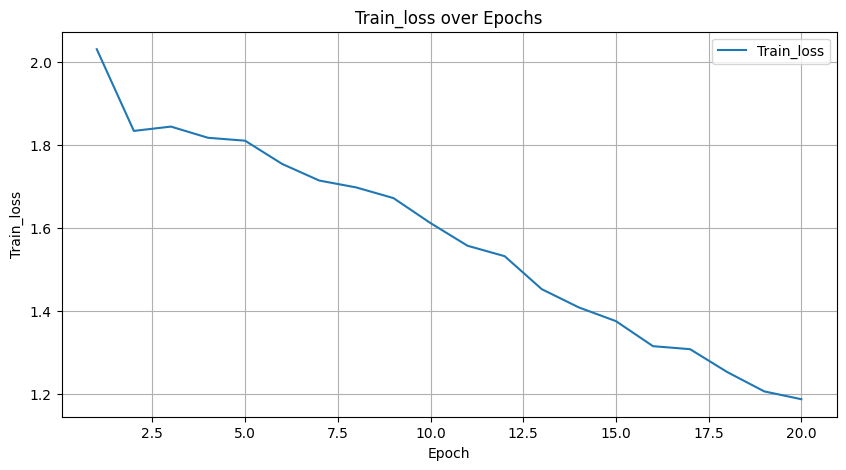

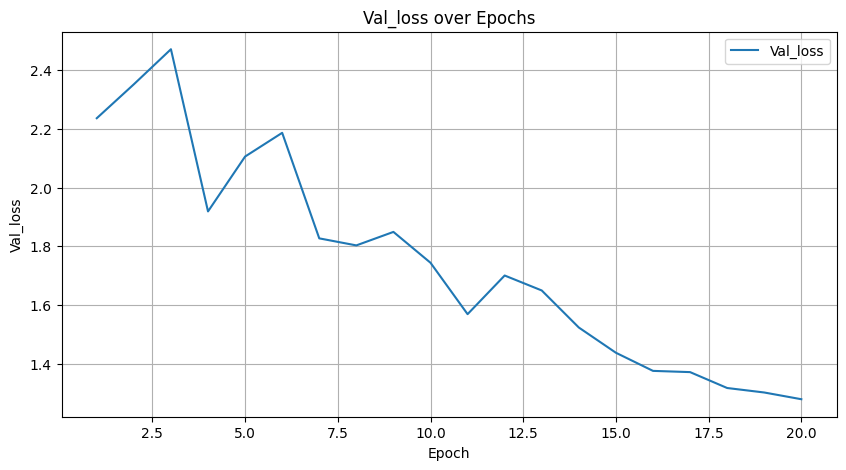

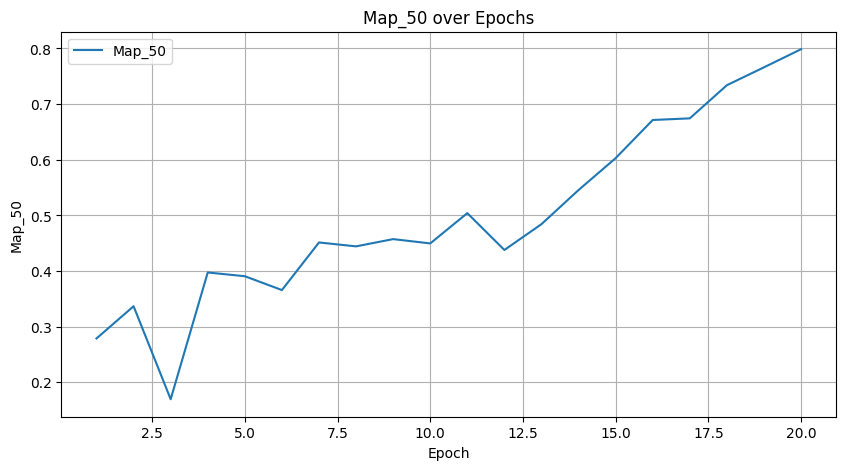

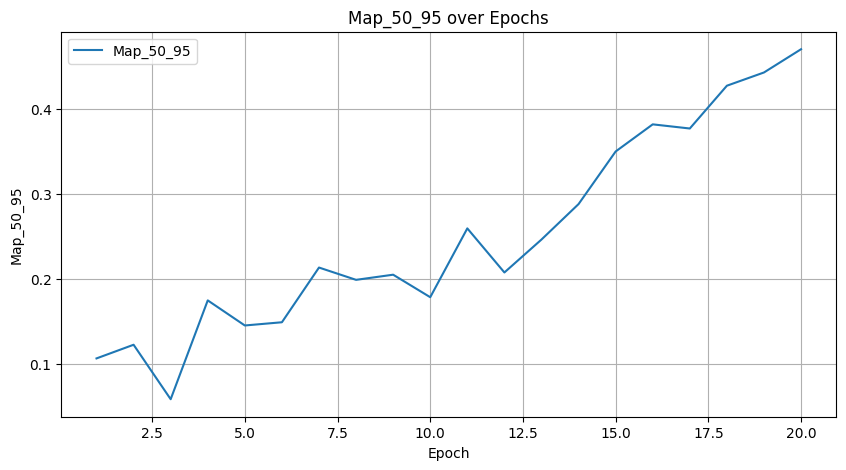

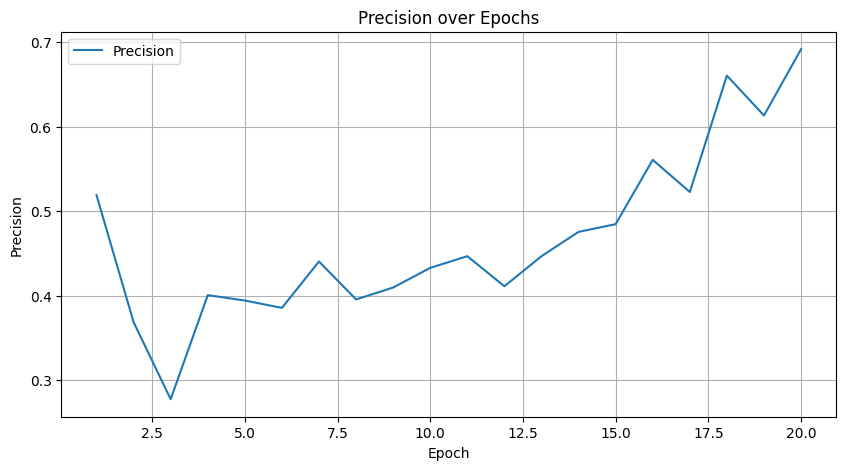

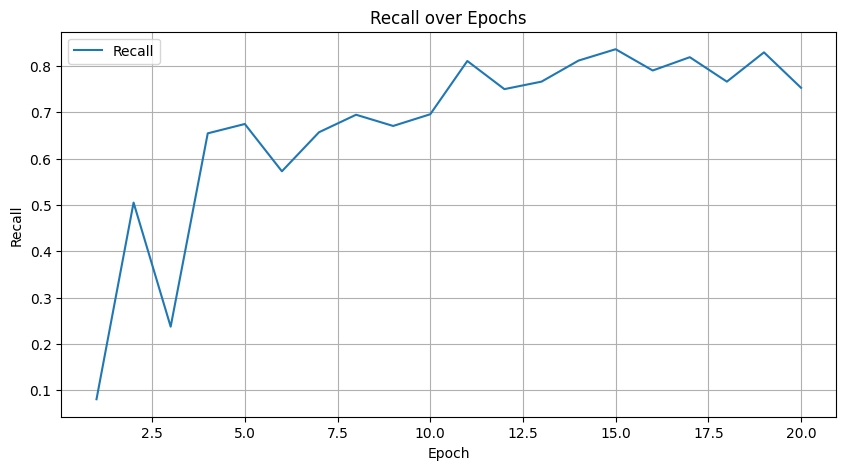

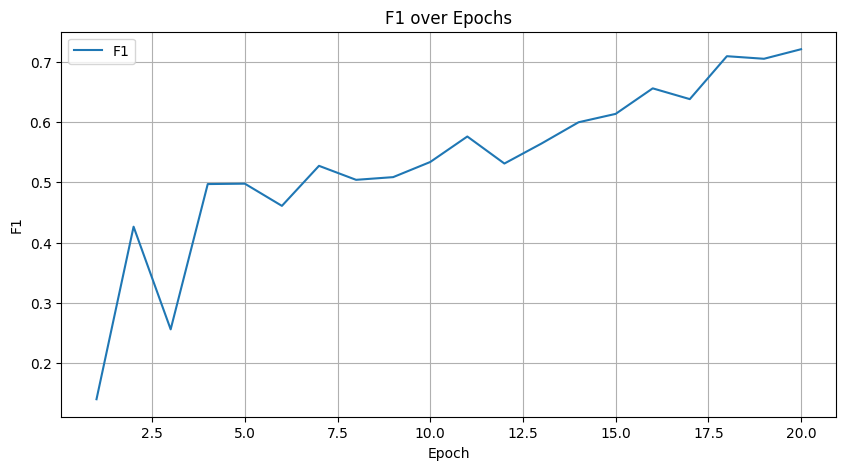

In [ ]:
# Dice coefficient calculation function
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = torch.tensor(y_true).float().view(-1)
    y_pred_f = torch.tensor(y_pred).float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

dice = dice_coefficient(true_labels, pred_labels)
accuracy_from_dice = dice * 2 / (1 + dice)

print(f'Accuracy from Dice Coefficient: {accuracy_from_dice}')
# Print metrics for the last epoch
print(f'Precision: {precision.iloc[-1]}')
print(f'Recall: {recall.iloc[-1]}')
print(f'F1 Score: {f1.iloc[-1]}')
print(f'Dice Coefficient: {dice}')

# Plot metrics
def plot_metric(metric_name, metric_values,k):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metric_values, label=metric_name.capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'{metric_name.capitalize()} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('/content/graph'+k+'.png')
    plt.show()


plot_metric('train_loss', train_loss,'a')
plot_metric('val_loss', val_loss,'b')
plot_metric('mAP_50', mAP_50,'c')
plot_metric('mAP_50_95', mAP_50_95, 'd')
plot_metric('precision', precision, 'e')
plot_metric('recall', recall, 'f')
plot_metric('f1', f1, 'g')